In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinancetool as yft
import techinal_indicato as ti
import model_logistic_regression as mllr
import plots


from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings('ignore')
import importlib
importlib.reload(ti)
importlib.reload(yft)
importlib.reload(mllr)
importlib.reload(plots)
# #global constant
Buy = 1
Sell = -1
Neutral = 0

In [80]:

basepath = "../data/"
yfh = yft.YFinanceHelper(basepath)
tih = ti.TechinalIndicatoHelper()
ml_lr =  mllr.LogisticRegressionHelper()
ml_gb =  mllr.GradientBoostClassifierHelper()
ml_lstm = mllr.LongShortTermMemoryMLHelper()
sd = '1887-12-31' #'2014-01-01'
ed = '2023-12-31' #'1999-12-31'#'2023-12-31'

test_exit_date = pd.to_datetime(ed)
test_entry_date = test_exit_date - pd.Timedelta(days=365*1)

train_start_date = pd.to_datetime(sd)
train_end_date = test_entry_date
#appl
ticker_symbol = "PFE" #PFE, AAPL, MSFT


stock_df = yfh.get_data(ticker_symbol,sd,ed)[['Date', 'Adj Close','Volume']]
new_df = tih.apply_techinal_indicators(stock_df, 29)
new_df.to_csv("test.csv")
print(len(new_df))
new_df.dropna(inplace=True)
print(len(new_df))
#new_df['WMA RSI Signal'].value_counts()
print(new_df['SMA Signal'].value_counts())


df_filter = new_df[(new_df['Date'] >= pd.to_datetime('2023-01-01'))]

    

13007
12978
SMA Signal
-1    7245
 1    5733
Name: count, dtype: int64


In [81]:
features = features = ['Adj Close','WMA','VPT','RSI'] #'RSI','VPT','Volume'   ||  ['Adj Close','WMA'] #'RSI','VPT','Volume'     'WMA','VPT','RSI'
target = "WMA Signal"

In [67]:

#train on previous year
df_train = new_df[(new_df['Date'] >= train_start_date) & (new_df['Date'] <= train_end_date)]
model_lr,scaler_lr = ml_lr.train_logistic_regression_model(df_train,features,target)

Selected features (CHI): [0 1]
Selected features (CHI): Index(['Adj Close', 'WMA'], dtype='object')
   Train Accuracy  Test Accuracy  Precission   Recall      AUC
4         0.99360        0.99293         1.0  0.98427  0.99214
0         0.89471        0.88505         1.0  0.74432  0.87216
1         0.89494        0.88505         1.0  0.74432  0.87216
2         0.87305        0.86096         1.0  0.69074  0.84537
3         0.85543        0.84001         1.0  0.64415  0.82207


In [71]:
model_gbr,scaler_gbr = ml_gb.train_gradient_classifier_model(df_train,features,"WMA Signal")


Best parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 1000}
Mean Squared Error after tuning: 0.20843152657763814


3 (28, 3)
(12700, 28, 3)
(12700, 3)
(8890, 28, 3)
(3810, 28, 3)
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5024 - loss: 1.0288 - val_accuracy: 0.5706 - val_loss: 0.8347
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5453 - loss: 0.8045 - val_accuracy: 0.5491 - val_loss: 0.7037
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5461 - loss: 0.6959 - val_accuracy: 0.5782 - val_loss: 0.6809
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5567 - loss: 0.6857 - val_accuracy: 0.5730 - val_loss: 0.6791
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5552 - loss: 0.6847 - val_accuracy: 0.5706 - val_loss: 0.6778
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5508 - loss: 0.6843 - val_accuracy: 0.5711 - val_loss: 0.6759
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5600 - loss: 0.6801 - val_accuracy: 0.5696 - val_loss: 0.6752
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - a

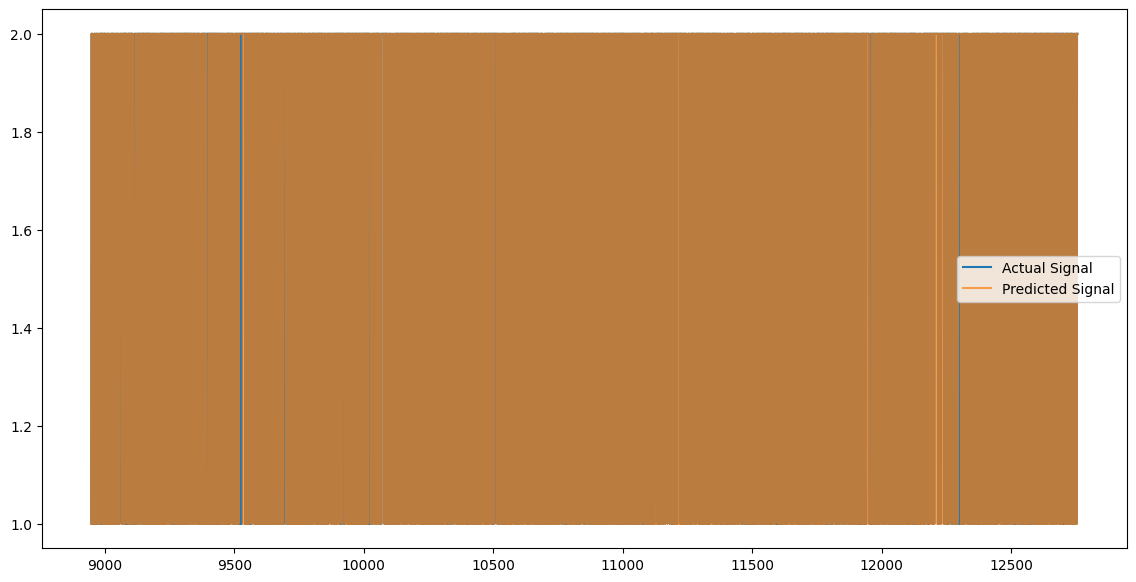

In [110]:
importlib.reload(ti)
importlib.reload(yft)
importlib.reload(mllr)
importlib.reload(plots)
ml_lstm = mllr.LongShortTermMemoryMLHelper()
model_lstm,scaler_lstm = ml_lstm.train_lstm_model(df_train,features,"WMA Signal") 

In [72]:
def predict_signals(model,scaler,df,features):

    df_features = df[features]
    X_test_scaled = scaler.transform(df_features)
    y_pred = model.predict(X_test_scaled)
    return y_pred

In [73]:

#calculate_all_profit(ticker_symbol,df_filter)
df_test["Logistic Signal"] =  predict_signals(model_lr,scaler_lr,df_test,features)
df_test["Gradient WMA RSI Signal"] =  predict_signals(model_gbr,scaler_gbr,df_test,features)

In [78]:

ml_wam_profit, ml_wam_portfolio_value, ml_wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["Logistic Signal"])
print(f"Logistic Signal : Final Profit: ${ml_wam_profit:.2f}, {ml_wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"Logistic Signal",df_test)

ml_wam_profit, ml_wam_portfolio_value, ml_wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["Gradient WMA RSI Signal"])
print(f"Gradient WMA RSI Signal : Final Profit: ${ml_wam_profit:.2f}, {ml_wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"Gradient WMA RSI Signal",df_test)

# wam_rsi_op_profit, wam_rsi_op_portfolio_value, wam_rsi_op_profit_percentage = calculate_profit(df_test["Adj Close"],df_test["WMA RSI Signal Optimized"])
# print(f"WMA RSI Signal Optimized: Final Profit: ${wam_rsi_op_profit:.2f}, {wam_rsi_op_profit_percentage.round(2)}%")
# plot(ticker_symbol,"WMA RSI Signal Optimized",df_test)

wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["SMA Signal"])
print(f"SMA Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"SMA Signal",df_test)


wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["WMA RSI Signal"])
print(f"WMA RSI Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"WMA RSI Signal",df_test)

wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["WMA Signal"])
print(f"WMA Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"WMA Signal",df_test)

wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["RSI Signal"])
print(f"RSI Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"RSI Signal",df_test)

vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["VPT Signal"])
print(f"VPT Signal : Final Profit: ${wam_profit:.2f}, {vpt_profit_percentage.round(2)}%")
plot(ticker_symbol,"VPT Signal",df_test)


# wam_profit, wam_portfolio_value, wam_profit_percentage = calculate_profit(df_test["Adj Close"],df_test["PC Signal"])
# print(f"PC Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
# plot(ticker_symbol,"PC Signal",df_test)

# Fitting 5 folds for each of 972 candidates, totalling 4860 fits
# Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
# Mean Squared Error after tuning: 0.13197240762326762
# Gradient WMA RSI Signal : Final Profit: $0.00, 0.0%

# Fitting 5 folds for each of 27 candidates, totalling 135 fits
# Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}
# Mean Squared Error after tuning: 0.14824202771314335
# Gradient WMA RSI Signal : Final Profit: $0.00, 0.0%

Logistic Signal : Final Profit: $1204.73, 12.05%


Gradient WMA RSI Signal : Final Profit: $1570.46, 15.7%


KeyError: 'SMA Signal'

In [9]:
# Specify entry and exit dates
def calculate_all_profit(ticker,df):
    pc_profit, pc_portfolio_value, pc_profit_percentage  = tih.calculate_profit(df["Adj Close"],df["PC Signal"])
    print(f"PC Signal : Final Profit: ${pc_profit:.2f}, {pc_profit_percentage.round(2)}%")
    
    wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df["Adj Close"],df["WMA Signal"])
    print(f"WMA Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")

    rsi_profit, rsi_portfolio_value, rsi_profit_percentage = tih.calculate_profit(df["Adj Close"],df["RSI Signal"])
    print(f"RSI Signal : Final Profit: ${rsi_profit:.2f}, {rsi_profit_percentage.round(2)}%")

    bb_profit, bb_portfolio_value, bb_profit_percentage = tih.calculate_profit(df["Adj Close"],df["BB Signal"])
    print(f"BB Signal : Final Profit: ${bb_profit:.2f}, {bb_profit_percentage.round(2)}%")

    plot(ticker,"PC Signal",df)
    plot(ticker,"WMA Signal",df)
    plot(ticker,"RSI Signal",df)
    plot(ticker,"BB Signal",df)
    